# Is the cinema sexist? 

**Authors**
- Marjorie Cayatte
- Maxime Leriche
- Madeleine Robert
- Arthur Tabary

**Date**\
November, 18th, 2022

In this Notebook, we present our initial analyses and results. We first import the necessay libraries. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import math
from scipy import stats
import json
from datetime import datetime, date, time
import requests
from scipy.stats import (gmean,
                        bootstrap)

## 1 - Get the different datasets

We import the following datasets from the **CMU Movie Summary Corpus** as DataFrame: 
- *movie.metadata.tsv.gz*: metadata for 81,741 movies, extracted from the November 4<sup>th</sup>, 2012 dump of Freebase. 
- *character.metadata.tsv.gz*: metadata for 450,669 characters aligned to the movies, extracted from the November 4<sup>th</sup>, 2012 dump of Freebase. 

In [3]:
# Import movie.metadata and format column names
movies = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv',sep='\t',header=None)
movies.columns=['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date','movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


- We will clean the DataFrame *movies* by splitting the columns with multiple data into multiple columns. For example, the column "movie_countries" contains the Freebase ID and the country. To do so, we tranform dictionnary in list which will be easier to manipulate. 

In [4]:
# Separate dictionaries into 2 columns with Freebase id and value
movies["movie_countries_id"] = movies["movie_countries"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_countries"] = movies["movie_countries"].map(eval).apply(lambda x: list(x.values()))
movies["movie_genres_id"] = movies["movie_genres"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_genres"] = movies["movie_genres"].map(eval).apply(lambda x: list(x.values()))
movies["movie_languages_id"] = movies["movie_languages"].map(eval).apply(lambda x: list(x.keys()))
movies["movie_languages"] = movies["movie_languages"].map(eval).apply(lambda x: list(x.values()))
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv]


In [5]:
# Load character metadata and format column names
characters = pd.read_csv('Data/MovieSummaries/character.metadata.tsv',sep='\t',header=None)
characters.columns = ['wiki_movie_ID','freebase_movie_ID','movie_release_date','character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']
characters.head()

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## 2 - What genre are included in the dataset ?

In this part, we analyze the feature "movie_genres" to understand how we can include it as a parameter to answer our main question. 

### 2.1 - Transform and clean the dataset

- We notice some corrupted values and correct them. 

In [6]:
# Warning, some rows of the dataset have wrong release dates: here 1010 instead of 2010
movies.iloc[62836]

wiki_movie_ID                                             29666067
freebase_movie_ID                                       /m/0fphzrf
movie_name                                          Hunting Season
movie_release_date                                      1010-12-02
movie_box_off_rev                                       12160978.0
movie_runtime                                                140.0
movie_languages               [Turkish Language, English Language]
movie_countries                                           [Turkey]
movie_genres             [Crime Fiction, Mystery, Drama, Thriller]
movie_countries_id                                     [/m/01znc_]
movie_genres_id       [/m/0lsxr, /m/02n4kr, /m/07s9rl0, /m/01jfsb]
movie_languages_id                        [/m/02hwyss, /m/02h40lc]
Name: 62836, dtype: object

In [7]:
# Replace the wrong value of 1010
movies.loc[62836, 'movie_release_date'] = '2010-12-02'

In [8]:
# Keep only the year of the release date
movies['movie_release_date'] = movies['movie_release_date'].str[:4]

### 2.2 - How many genre a movie has? 

- We first want to know how many genre a movie has to better understand how this characterize the movie.

In [9]:
# Compute the number of reported genre by movie
movies['nb_genres'] = movies['movie_genres'].str.len()
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,nb_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],7
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],4
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],2
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],3
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],1


- We can look at basic statistics on "nb_genres" and plot the distribution. 

In [10]:
movies['nb_genres'].describe()

count    81741.000000
mean         2.976829
std          2.107219
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         17.000000
Name: nb_genres, dtype: float64

<AxesSubplot: >

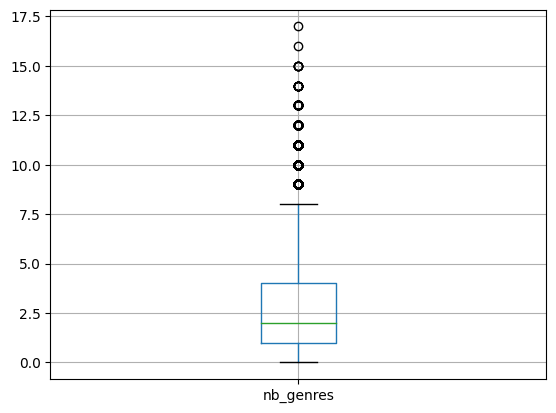

In [11]:
# Plot the distribution of "nb_genres"
movies.boxplot(['nb_genres'])

- With the boxplots and the statistics of the new column "nb_genres", we notice that a movie can have 17 genres. Such a high number of genre does not seem necessary to describe the genre of a movie. But most of the movies (75%) have between 1 and 4 genres which is more reasonable. For further analysis on genre impact we could think of keeping only a small number of genre. 

### 2.3 - What are the genre the most represented in the dataset? 

- We now look at the opposite point of view: how many movies are reported for each genre? 

In [12]:
# Explode the list in individual genre and count how many movies are reported for each genre
total_genres = pd.DataFrame(movies.movie_genres.explode().dropna().value_counts())
total_genres

,movie_genres
Drama,34007
Comedy,16349
Romance Film,10234
Black-and-white,9094
Action,8798
...,...
Romantic thriller,1
Comdedy,1
C-Movie,1
Silhouette animation,1


<AxesSubplot: title={'center': 'Number of movies by genre'}, xlabel='Genres'>

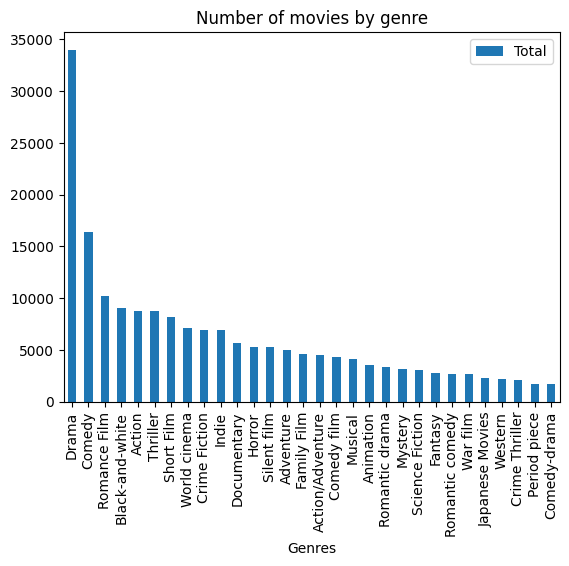

In [13]:
# Plot the number of movies reported for each genre
total_genres.index.name = "Genres"
total_genres = total_genres.rename(columns = {'movie_genres': 'Total'})
total_genres.head(30).plot.bar(y = 'Total', title = "Number of movies by genre")

- Here we see that the number of movies by genre decreases almost exponentially. Among the genre in the tail, we find cross genre like "Romantic Thriller" or error of typology like "Comdedy". There are also some categories which are not strict genres like "silent movie" or "black and white". Keeping them in our analysis does not seem pertinent as they do not reflect a trend intrinsic to a genre.

- For future analyses on genre, we chose to retain only the **5 genre the most represented in the dataset**, excluding the "Black and White" category, which we not consider as a genre: 
    - Drama
    - Comedy 
    - Romance film 
    - Action
    - Thriller

- This choice is supported by the fact that they correspond to natural responses one would answer when asked about most represented genre.

### 2.5 - Evolution over time

- Has the evolution of most represented genre changed over time?  

In [14]:
# Group by "movie_release_date"
movies_per_year_grouped = movies.groupby(movies['movie_release_date'])

# Compute the number of movies by year and by genre
total_genres_per_year = total_genres
years = ['Total']
for year, group in movies_per_year_grouped[['movie_release_date', 'movie_genres']]:
    total_genres_per_year = pd.concat([total_genres_per_year, group.movie_genres.explode().dropna().value_counts()], axis = 1)
    years.append(year)
total_genres_per_year.columns = years
total_genres_per_year.index.name = 'Genres'
total_genres_per_year.head()

,Total,1888,1889,1890,1891,1892,1893,1894,1895,1896,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Genres,,,,,,,,,,,,,,,,,,,,,
Drama,34007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1013.0,985.0,966.0,902.0,842.0,427.0,45.0,4.0,NaN,NaN
Comedy,16349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,...,496.0,512.0,444.0,393.0,267.0,98.0,10.0,1.0,NaN,NaN
Romance Film,10234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,332.0,349.0,320.0,283.0,261.0,172.0,13.0,3.0,NaN,1.0
Black-and-white,9094,1.0,1.0,NaN,NaN,NaN,1.0,7.0,11.0,19.0,...,3.0,2.0,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN
Action,8798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,239.0,286.0,269.0,287.0,294.0,187.0,44.0,1.0,2.0,1.0


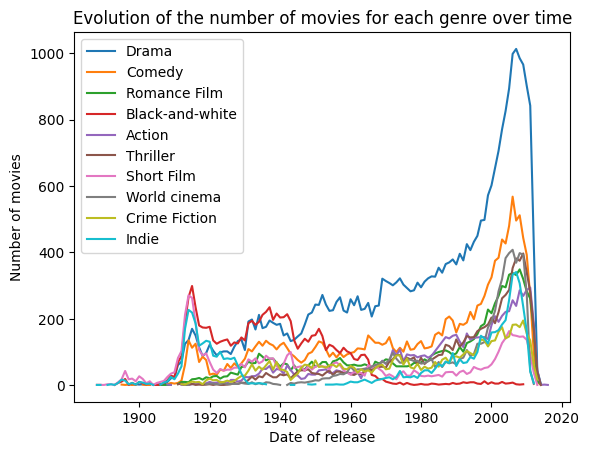

In [15]:
# Plot the evolution of the number of movies by genre the the top 10
x = np.array(total_genres_per_year.columns[1:], dtype = 'datetime64[ms]')
plt.figure()
for index, row in total_genres_per_year.head(10).iterrows():
    plt.plot(x, row[1:], label = index)
plt.legend()
plt.xlabel("Date of release")
plt.ylabel("Number of movies")
plt.title("Evolution of the number of movies for each genre over time")
plt.show()

- By looking at the number of genre per year, we see a similar evolution for every genre. For every genre the number of movies highly increases,  except for "black and white" movies. The striking drop around 2010 probably corresponds to time of extraction of the database (2012).

- We can look at the counts. 

In [16]:
movies_per_year_grouped[['movie_release_date']].size().reset_index(name='counts').sort_values(by = 'movie_release_date', ascending= False).head(10)

,movie_release_date,counts
128,2016,3
127,2015,4
126,2014,17
125,2013,164
124,2012,1194
123,2011,1824
122,2010,2023
121,2009,2247
120,2008,2465
119,2007,2389


- As we can see here, values are incoherent after 2013. Therefore, we will **cut off after 2012 (included)**, which is coherent with the date of extraction of the database. 

- According to the following graph made with IMDB dataset, the behavior of the number of movie by year is similar, which supports the hypothesis that the dataset provides evolution close to reality.
![films-released-yearly](films-released-all-time-yearly.png)

## 3 - Geographic distribution of movies

### 3.1 - Gather region for each country

- For this part, we use an online API which provides varied data about each country, and will use the name given in the dataset to gather the corresponding region.

- Since both datasets come from different sources, it is likely that the country names won't match, so we might need to do some changes. 

In [17]:
# Get region for each country

region_lst = ["Africa", "Americas", "Asia", "Europe", "Oceania"]
countries = {"country" : [],
"region" : []}

country_lst = [[], []]
df_countries = pd.DataFrame(columns = ["country", "region"])

for region in region_lst:
    response = requests.get("https://restcountries.com/v3.1/region/" + region).json()

    for elem in response:
        countries["country"].append(elem.get("name").get("common"))
        countries["region"].append(region)

df_countries = pd.DataFrame.from_dict(countries)
df_countries.head()

,country,region
0,Mauritania,Africa
1,Niger,Africa
2,Togo,Africa
3,Madagascar,Africa
4,Algeria,Africa


### 3.2 - Missing countries in our country-region table

We now want to answer the following questions: 
- What are the unreferenced countries?
- For each of these countries, how many movies did they produce/co-produce?
- Which country reprensent 95% of all thoses movies? 

We could then keep only these countries, and update the country-region reference table. 

There is a total of 8053 movies that contain a null movie name (NaN) among the producing countries (movie_countries column)
98.87% of them only contain 1 NaN occurence, up to 7962.


1    7962
2      83
3       7
5       1
dtype: int64

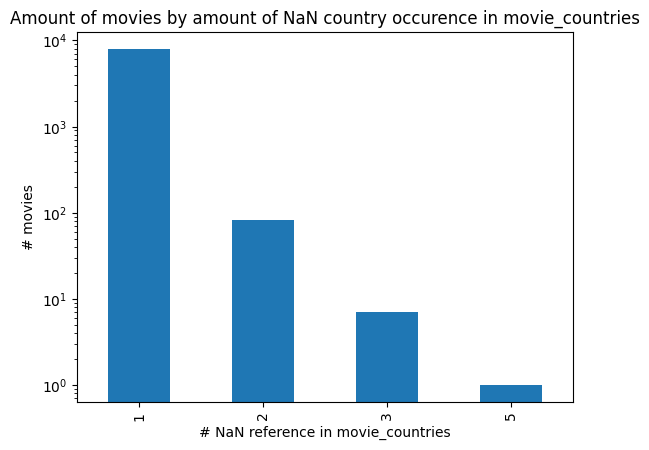

In [18]:
all_movie_countries = movies.explode("movie_countries", ignore_index = True)
unique_movie_countries = all_movie_countries.loc[all_movie_countries["movie_countries"].isnull()]
grunique_movie_countries = unique_movie_countries.groupby("movie_name").size()
grunique_movie_countries = grunique_movie_countries.groupby(grunique_movie_countries).size()
ax = grunique_movie_countries.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("# NaN reference in movie_countries") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies by amount of NaN country occurence in movie_countries");
print(f"There is a total of {grunique_movie_countries.sum()} movies that contain a null movie name (NaN) among the producing countries (movie_countries column)")
print(f"{grunique_movie_countries.iloc[0]/grunique_movie_countries.sum() :.2%} of them only contain 1 NaN occurence, up to {grunique_movie_countries.max()}.")
grunique_movie_countries

95% of these movies come from ['United States of America' 'West Germany']


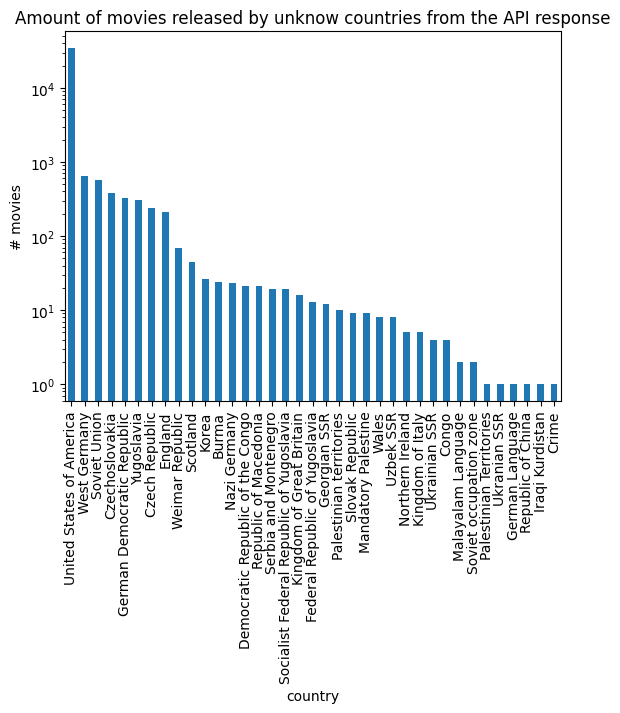

In [19]:
######################################
# What are the unreferenced countries?
######################################

# Get all unique countries in our dataset
all_movie_countries = movies["movie_countries"].explode(ignore_index = True)
unique_movie_countries = all_movie_countries.unique()

# Referenced unique countries
referenced_countries = df_countries["country"].unique()

# Unreferenced countries in the dataset
unreferenced = [a for a in unique_movie_countries if a not in referenced_countries]

###########################################################################
# For each of these countries, how many movies did they produce/co-produce?
###########################################################################

df_unreferenced = all_movie_countries.groupby(all_movie_countries).size()
df_unreferenced = df_unreferenced[df_unreferenced.index.isin(unreferenced)].sort_values(ascending = False)

# Plot
ax = df_unreferenced.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("country") 
ax.set_ylabel("# movies")
ax.set_title("Amount of movies released by unknow countries from the API response");

# Get country names representing 95% of movie quantity
percentile_95 = df_unreferenced.sum() * 0.95
countries_to_keep = df_unreferenced[df_unreferenced.cumsum() <= percentile_95]

print(f"95% of these movies come from {countries_to_keep.index.values}")

# Add these countries to the API dataframe response
countries_to_add = dict(zip(["country", "region"], [countries_to_keep.index.values.tolist(), ["Americas", "Europe"]]))
countries_to_add = pd.DataFrame.from_dict(countries_to_add)
df_countries = pd.concat([df_countries, countries_to_add], ignore_index=True)


# Update the list of unreferenced countries
for country in countries_to_keep.index.values.tolist():
    unreferenced.pop(unreferenced.index(country))

### 3.3 - Clean dataset

- We now remove all movies with a "movie_country" item in one of the unreferenced country we do not want to consider.

In [20]:
movie_count = len(movies)
movies = movies[movies.movie_countries.apply(lambda x: not any(i in unreferenced for i in x))]
print(f"{movie_count - len(movies)} movies were removed.")

2282 movies were removed.


### 3.4 - Add the region information to our dataset

- The *region* column contains the continent in which the movie was produced (can be different regions if multiple countries from different continent co-produced the movie).

In [21]:
# Add region column
# For each country in movies.movie_countries, get the region (remove region duplicates)
def get_region(country_lst):
    output = []
    for country in country_lst:
        try:
            output.append(df_countries.loc[df_countries["country"] == country]["region"].values[0])
        except:
            raise KeyError(f"{country} not found in the reference list")

    #remove duplicates
    return list(set(output))

movies_copy = movies.copy()
movies_copy["region"] = movies_copy.loc[:, ("movie_countries")].apply(lambda x: get_region(x))
movies = movies_copy.copy()
movies.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,nb_genres,region
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],7,[Americas]
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],4,[Americas]
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],2,[Europe]
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],3,[Europe]
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],1,[Europe]


### 3.5 - Movie repartition by region

- Which region (or continent) are the most represented in the dataset

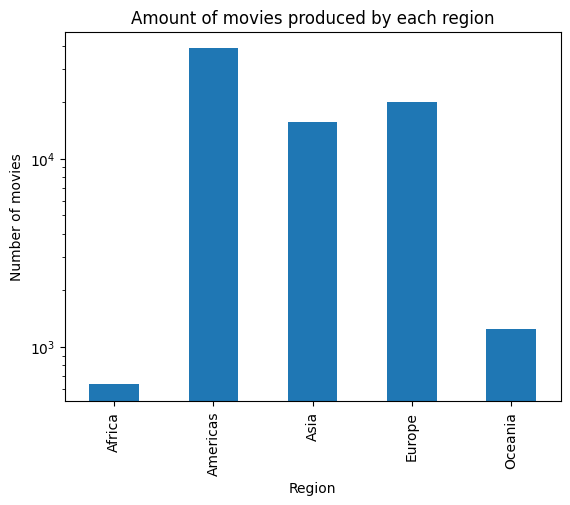

In [22]:
# Plot the distribution of the number of movies by region
movies_region = movies["region"].explode()
movies_region = movies_region.groupby(movies_region).size()
ax = movies_region.plot.bar()
ax.set_yscale("log")
ax.set_xlabel("Region") 
ax.set_ylabel("Number of movies")
ax.set_title("Amount of movies produced by each region");

## 4 - Age and height between male and female characters

We want to compare different features between roles played by male or female: *characters* provides age and height of actors, which can be compared between genders. 

### 4.1 - Evaluating and filtering out missing values

In [23]:
# Create a DataFrame keeping only characters where actors have reported gender
characters_gender = characters[characters["actor_gender"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains {} rows.'.format(len(characters_gender) / len(characters), len(characters_gender)))

 89.9% of the DataFrame "characters" has reported gender, the corresponding DataFrame "characters_gender" contains 405060 rows.


In [24]:
# What are the possible different values for characters_gender? 
pd.Categorical(characters_gender.actor_gender)

['F', 'F', 'M', 'M', 'F', ..., 'F', 'M', 'F', 'M', 'M']
Length: 405060
Categories (2, object): ['F', 'M']

### 4.2 - What is the repartition between male and female characters? 

66.72% of reported characters are played by male actors.


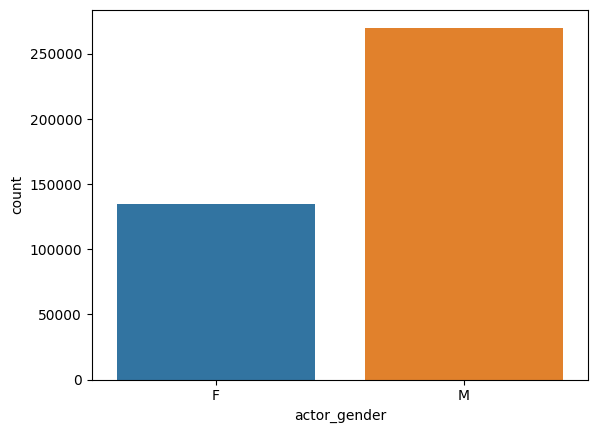

In [25]:
# Create two DataFrame for characters played by female/male
characters_female = characters_gender[characters_gender['actor_gender']== 'F']
characters_male = characters_gender[characters_gender['actor_gender']== 'M']

# Plot the repartition
sns.countplot(x = characters_gender['actor_gender'])
print("{:.2%} of reported characters are played by male actors.".format(len(characters_male)/len(characters_gender)))

### 4.3 - How is age of male characters compared to age of female characters? 

- We want to compare age of the actors and actresses palying roles reported in *character*. 

In [26]:
# Clear out characters_gender where age is not reported (characters_gender_age)
characters_gender_age = characters_gender[characters_gender["actor_age_movie"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains {} rows.'.format(len(characters_gender_age) / len(characters), len(characters_gender_age)))

 64.5% of the DataFrame "characters" has reported gender and age of the actor/actress; the corresponding DataFrame "characters_gender_age" contains 290770 rows.


- We first explore and clean the data. 

In [27]:
# Explore basic statistics
characters_gender_age.describe()

,wiki_movie_ID,actor_height,actor_age_movie
count,2.907700e+05,139639.000000,290770.000000
mean,1.302929e+07,1.789524,37.804148
std,1.080402e+07,4.380801,20.616015
min,3.300000e+02,0.610000,-7896.000000
25%,3.052538e+06,1.680000,28.000000
50%,1.014264e+07,1.750000,36.000000
75%,2.261175e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


- The negative values do not make sense: we filter them out.

In [28]:
# Keep only rows where "actor_age_movie" is positive
characters_gender_age = characters_gender_age[characters_gender_age['actor_age_movie'] >= 0]

- We plot age of actors in the movie in a boxplot. 

Text(0, 0.5, 'Age (years)')

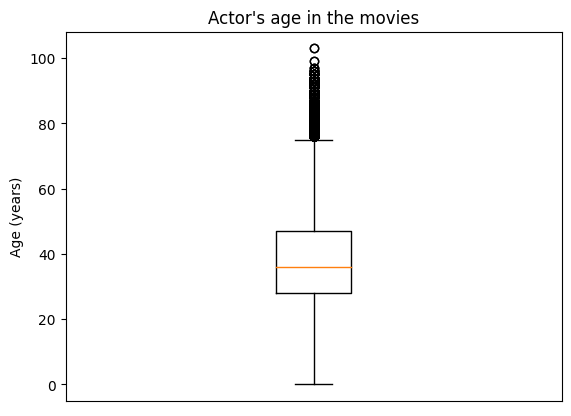

In [29]:
# Plot the distribution of age of actors
plt.boxplot(characters_gender_age['actor_age_movie'])
plt.xticks([])
plt.title("Actor's age in the movies")
plt.ylabel("Age (years)")

- We can visualize age of actors by gender. 

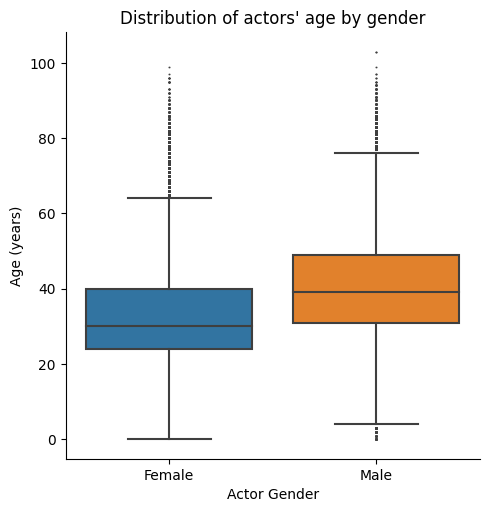

In [30]:
# Plot distribution of age by gender
g = sns.catplot(data=characters_gender_age, x="actor_gender", y="actor_age_movie", kind="box", fliersize=0.5).set(title="Distribution of actors' age by gender")
g.set_axis_labels("Actor Gender", "Age (years)")
g.set_xticklabels(["Female", "Male"])

### 4.4 - How about height? 

- We can perform the same analysis for height. 

In [31]:
# Clear out characters_gender where height is not reported (characters_gender_age)
characters_gender_height = characters_gender[characters_gender["actor_height"].notnull()]
print('{: .1%} of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains {} rows.'.format(len(characters_gender_height) / len(characters), len(characters_gender_height)))

 34.3% of the DataFrame "characters" has reported gender and height of the actor/actress; the corresponding DataFrame "characters_gender_height" contains 154663 rows.


In [32]:
# Explore basic statistics on height
characters_gender_height["actor_height"].describe()

count    154663.000000
mean          1.788966
std           4.382216
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max         510.000000
Name: actor_height, dtype: float64

- 510 cm seems to be a corrupted value. We filter rows where height is above 2,72m (biggest height reported).

In [33]:
# Keep only rows where "actor_height" is below 2.72m
characters_gender_height = characters_gender_height[characters_gender_height['actor_height'] < 2.73]

- Are there other outliers? 

Text(0, 0.5, 'Height (cm)')

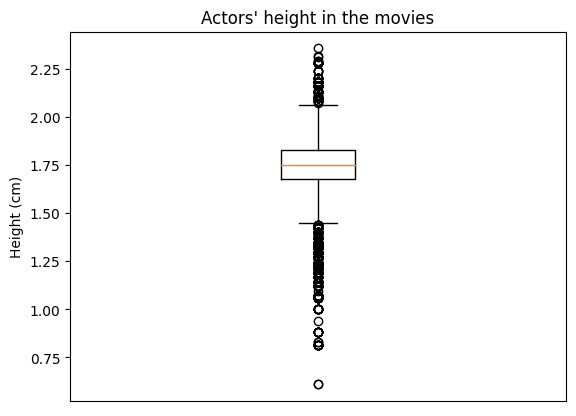

In [34]:
# Plot the distribution of height of actors
plt.boxplot(characters_gender_height['actor_height'])
plt.xticks([])
plt.title("Actors' height in the movies")
plt.ylabel("Height (cm)")

- We can visualize height by gender. 

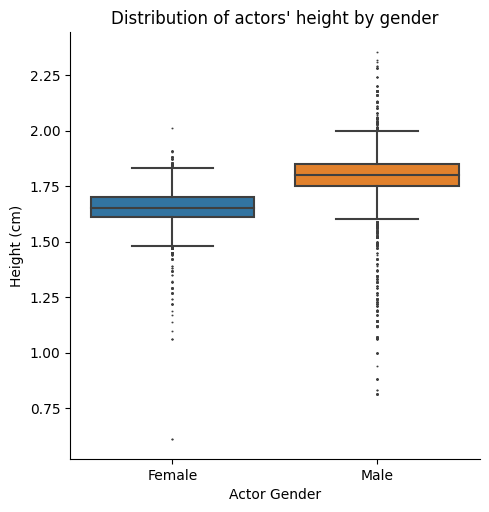

In [35]:
# Plot the distribution of height by gender
g = sns.catplot(data=characters_gender_height, x="actor_gender", y="actor_height", kind="box", fliersize=0.5).set(title="Distribution of actors' height by gender")
g.set_axis_labels("Actor Gender", "Height (cm)")
g.set_xticklabels(["Female", "Male"])

- It seems that male characters have more outliers than female characters. 

### 4.5 - Are the observed differences statistically significant? 

- We look at average age and height between male and female characters. 

In [36]:
# In the movies where characters are reported, actresses are on average smaller and younger than men 
characters_gender_grouped = characters_gender.groupby("actor_gender")[["actor_gender", "actor_age_movie", "actor_height"]].mean()
characters_gender_grouped.head()

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_36593/882964396.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  characters_gender_grouped = characters_gender.groupby("actor_gender")[["actor_gender", "actor_age_movie", "actor_height"]].mean()


,actor_age_movie,actor_height
actor_gender,,
F,32.810753,1.659008
M,40.391679,1.863798


- Are these differences statistically significant? \
To answer this question, we perform an independent sample t-test under the null hypothesis: there is no difference between actors' and actresses'a age. 

In [37]:
# We first extract rows where character is played by a woman or by a man
characters_female_age = characters_gender_age[characters_gender_age['actor_gender']== 'F']
characters_male_age = characters_gender_age[characters_gender_age['actor_gender']== 'M']
print("{:.2%} of characters were gender and age are reported are male.".format(len(characters_male_age)/len(characters_gender_age)))
print("The DataFrame characters_female_age has {} rows, characters_male_age has {} rows.".format(len(characters_female_age), len(characters_male_age)))

65.87% of characters were gender and age are reported are male.
The DataFrame characters_female_age has 99124 rows, characters_male_age has 191277 rows.


In [38]:
# characters_female and characters_male do not have the same shape, we extract 99 242 rows from characters_male to have the same shape to perform an independent t-test
characters_male_age_corr = characters_male_age.sample(n=len(characters_female_age), replace=False)

# We perform the independent sample t-test to compare age of female and male actors
stat_indep_age, pvalue_indep_age = stats.ttest_ind(characters_female_age['actor_age_movie'], characters_male_age_corr['actor_age_movie'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_age))

The p-value for the independent sample t-test is: 0.0


- Here, the p-value is probably below a certain treshold and Pyhton returns 0. \
As the p-value verifies $ p < 0.05 $, actresses are significantly younger in movies of the dataset than actors, with 95% confidence. 

In [39]:
# We now do the same t-test to compare height of male and female actors
characters_female_height = characters_gender_height[characters_gender_height['actor_gender']== 'F']
characters_male_height = characters_gender_height[characters_gender_height['actor_gender']== 'M']
print("{:.2%} of characters were gender and age are reported are male.".format(len(characters_male_height)/len(characters_gender_height)))
print("The DataFrame characters_female has {} rows, characters_male has {} rows.".format(len(characters_female_height), len(characters_male_height)))

63.46% of characters were gender and age are reported are male.
The DataFrame characters_female has 56515 rows, characters_male has 98133 rows.


In [40]:
# characters_female and characters_male do not have the same shape, we extract 56 515 rows from characters_male to have the same shape to perform an independent t-test
characters_male_corr2 = characters_male_height.sample(n=len(characters_female_height), replace=False)

# We perform the independent sample t-test to compare age of female and male actors
stat_indep_height, pvalue_indep_height = stats.ttest_ind(characters_female_height['actor_height'], characters_male_corr2['actor_height'])
print("The p-value for the independent sample t-test is: {}".format(pvalue_indep_height))

The p-value for the independent sample t-test is: 0.0


- Here again the p-value verifies $ p < 0.05 $ so actresses are significantly smaller in movies of the dataset than actors, with 95% confidence. 

### 4.6 - Is there a correlation between age and gender, or between height and gender? 

Is gender correlated with age of actors in the movies ? 

In [41]:
# Transform categorical value "actor_gender" into a numerical one
characters_gender_age_num = pd.get_dummies(data = characters_gender_age[['actor_gender', 'actor_age_movie']])

# We perform a Pearson correlation between gender and age of actors
stats.pearsonr(characters_gender_age_num['actor_gender_F'], characters_gender_age_num['actor_age_movie'])

PearsonRResult(statistic=-0.25300331810889787, pvalue=0.0)

- There is a small (-0.26) but significant ($ p < 0.05 $) negative correlation. 

In [42]:
# We can also examine Spearman rank correlation
stats.spearmanr(characters_gender_age_num['actor_gender_F'], characters_gender_age_num['actor_age_movie'])

SpearmanrResult(correlation=-0.2861287228160736, pvalue=0.0)

- Spearman rank correlation is also significant. 

- These analyses on age and height could be useful in further analyses to understand how characters played by men and women differ and what lead to these differences. 

## 5 - Representation of women in movies

### 5.1 - Percentage of women in movies

- First, we want to compute the percentage of women in each movie where there is a reported character with a gender. 

In [43]:
# creation of a column with "True" for womens
characters_gender['female'] = characters_gender.actor_gender=='F'

# compute percentage of women by movie
percentage_female=  characters_gender.groupby(characters_gender['freebase_movie_ID'])[['freebase_movie_ID','female']].mean()
percentage_female.head()

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_36593/1310754118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_gender['female'] = characters_gender.actor_gender=='F'
/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_36593/1310754118.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  percentage_female=  characters_gender.groupby(characters_gender['freebase_movie_ID'])[['freebase_movie_ID','female']].mean()


,female
freebase_movie_ID,
/m/011_mj,0.142857
/m/011_p6,0.400000
/m/011_zy,0.250000
/m/011wtv,0.333333
/m/011x_4,0.294118


We create a new DataFrame where we merge *movies* with *percentage_female* to add the percentage of female for each movie. 

In [44]:
movies_female = movies.merge(percentage_female, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
movies_female.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,movie_genres_id,movie_languages_id,nb_genres,region,female
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",[/m/02h40lc],7,[Americas],0.352941
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]",[/m/02h40lc],4,[Americas],0.266667
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],"[/m/0lsxr, /m/07s9rl0]",[/m/05f_3],2,[Europe],0.500000
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",[/m/07ssc],"[/m/01jfsb, /m/0glj9q, /m/09blyk]",[/m/02h40lc],3,[Europe],0.500000
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],[/m/07s9rl0],[/m/04306rv],1,[Europe],0.333333


- How many movies did we lose by merging? 

In [45]:
print("We kept {:.2%} of the DataFrame movies by merging.".format(len(movies_female)/len(movies)))

We kept 78.42% of the DataFrame movies by merging.


### 5.2 - Temporal evolution of female percentage in movies

We now want to examine how female percentage in movies evolved over time. 

In [46]:
movies_female_gp_year=movies_female.groupby(movies_female['movie_release_date'])[['movie_release_date','female']].mean()
movies_female_gp_year.head()

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_36593/2222213228.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  movies_female_gp_year=movies_female.groupby(movies_female['movie_release_date'])[['movie_release_date','female']].mean()


,female
movie_release_date,
1888,0.50
1891,0.00
1893,0.00
1894,0.25
1895,0.00


- We want to plot the percentage of women over time.

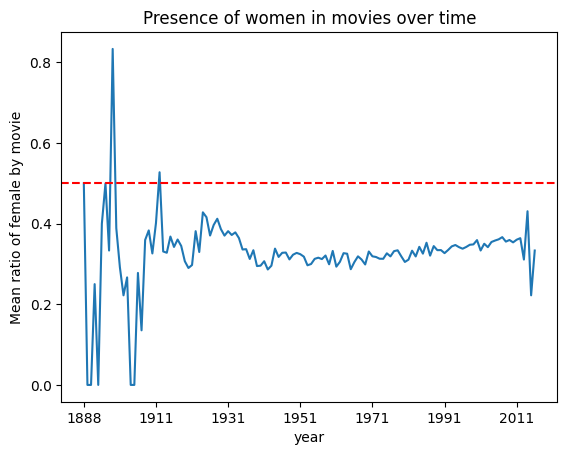

In [47]:
movies_female_gp_year.plot(legend=False)
plt.ylabel('Mean ratio of female by movie')
plt.xlabel('year')
plt.title('Presence of women in movies over time')
plt.axhline(y=0.5,color ='red', ls='--')

## 6 - How to evaluate the success of a movie ? 

In our dataset, the only feature we have to measure the success of a movie is the box office revenue. We will first analyze this feature on our dataset. 

### 6.1 - Cleaning and missing values

In [48]:
print("{:.2%} of the movies have a missing movie box office revenue value".format(movies.isnull().sum()['movie_box_off_rev']/len(movies)))

89.52% of the movies have a missing movie box office revenue value


- How are the missing values distributed over time ? 
- We calculate the number of movies per year which have a reported box office revenue. 

In [49]:
#Keep only movies with a value for box office revenue
movies_with_bor = movies[movies.movie_box_off_rev.isnull()==False]

#Group by year and count the number of movies
movies_with_bor_gp_year=movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_release_date']].count()
movies_with_bor_gp_year.head()

,movie_release_date
movie_release_date,
1897,1
1914,4
1915,1
1920,1
1921,3


- To plot evolution of movies without missing values over time, we normalize on the total number of movies, as we saw in 2 that it strongly increased over time. 

In [50]:
#Compute number of movies with missing values over total number of movies per year
movie_count_all_gp_year = movies.groupby(movies['movie_release_date'])[['movie_release_date']].count()
movie_count_all_gp_year['ratio_bor']=movies_with_bor_gp_year['movie_release_date']/movie_count_all_gp_year['movie_release_date']

Text(0.5, 1.0, 'Ratio of values available per year for the feature "movie_box_off_rev"')

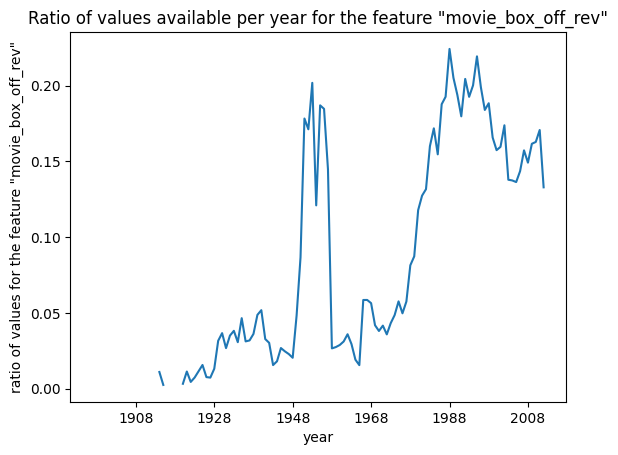

In [51]:
#Plot the distribution
movie_count_all_gp_year['ratio_bor'].plot(legend=False)
plt.ylabel('ratio of values for the feature "movie_box_off_rev"')
plt.xlabel('year')
plt.title('Ratio of values available per year for the feature "movie_box_off_rev"')

We can see that the ratio of movies without missing values increases with time; however, the ratio never exceeds 20% of the dataset, which is quite low. 

### 6.2 - Evolution of average box office revenue over time

We now want to analyze the evolution of the box office revenue over time. 

In [52]:
#Compute the average box office revenue by year
movies_mean_bor_gp_year = movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_box_off_rev']].mean()
movies_mean_bor_gp_year.head()

,movie_box_off_rev
movie_release_date,
1897,1.000000e+05
1914,7.079320e+05
1915,5.000000e+07
1920,4.500000e+06
1921,2.633333e+06


Text(0.5, 1.0, 'Evolution of the average box office revenue')

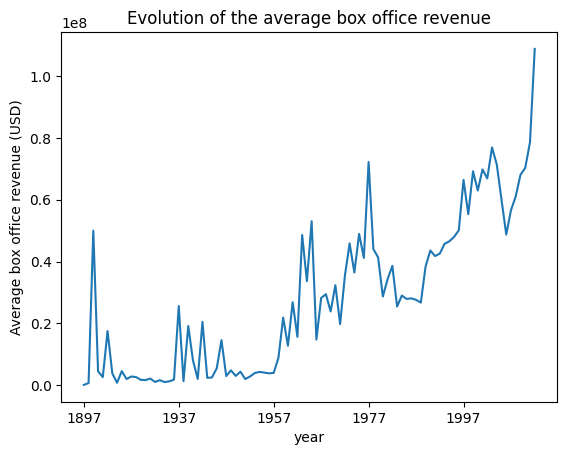

In [53]:
#Plot the distribution
movies_mean_bor_gp_year.plot(legend=False)
plt.ylabel('Average box office revenue (USD)')
plt.xlabel('year')
plt.title('Evolution of the average box office revenue')

* To be perfectly accurate in comparing box office receipt comparison over time, we should at least adjust revenues for dollar inflation. One could go further and consider even more adjustements to be even more precise as explained in [this article](https://wwwold.usi.edu/media/3655032/How-the-MPA-Miscalculates.pdf).

- Even if these results are interesting, the amount of missing values is quite problematic. To evaluate the success of a movie, we can also look at the ratings of the movies. The data is not available in our dataset but we can use IMDb.

<span style="color:red">**ADD CPI ADJUST HERE** </span>

### 6.3 - Get the IMDb dataset

In [54]:
# Import dataset title.basics and title.ratings
imdb_data_df = pd.read_csv('Data/Imdb/title.basics.tsv', sep = '\t')
imdb_ratings_df = pd.read_csv('Data/Imdb/title.ratings.tsv', sep = '\t')

imdb_data_df.head(10)

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_36593/3701626548.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_data_df = pd.read_csv('Data/Imdb/title.basics.tsv', sep = '\t')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short"
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short"


In [55]:
imdb_ratings_df.head(10)

,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1733
3,tt0000004,5.6,174
4,tt0000005,6.2,2544
5,tt0000006,5.1,175
6,tt0000007,5.4,797
7,tt0000008,5.4,2063
8,tt0000009,5.2,200
9,tt0000010,6.9,6962


In [56]:
# Merge imdb_data_df and imdb_ratings_df on ratings
rating_df = imdb_data_df.merge(imdb_ratings_df)

In [57]:
# Delete unnessary columns  
rating_df = rating_df.drop(['isAdult', 'endYear'], axis = 1)

In [58]:
rating_df.iloc[423117]

tconst                          tt0924400
titleType                           video
primaryTitle      007: Licence to Restore
originalTitle     007: Licence to Restore
startYear                            2006
runtimeMinutes                         13
genres                  Documentary,Short
averageRating                         7.5
numVotes                               73
Name: 423117, dtype: object

In [59]:
#Replace \N by NaN, replace corrupted values, drop missing values and convert run time into numerical data
rating_df[['runtimeMinutes', 'startYear']] = rating_df[['runtimeMinutes', 'startYear']].replace(r"\N", np.NaN).replace("Game-Show", np.NaN).replace("Game-Show,Reality-TV", np.NaN).dropna(subset = ['runtimeMinutes', 'startYear'])
rating_df = rating_df.dropna(subset = 'runtimeMinutes')
rating_df['runtimeMinutes'] = pd.to_numeric(rating_df['runtimeMinutes'])

In [60]:
#Merge movies with ratings_df on primary title and start year
merged_rating_df = movies.merge(rating_df, left_on = ['movie_name', 'movie_release_date'], right_on = ['primaryTitle', 'startYear'])
merged_rating_df.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,...,region,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],...,[Americas],tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55235
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",[/m/05b4w],...,[Europe],tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],[/m/0345h],...,[Europe],tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,589
3,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",[/m/09c7w0],...,[Americas],tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",[/m/09c7w0],...,[Americas],tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2159


- There are some duplicates because of the merge, we have to treat them. 

In [61]:
# Remove duplicates
merged_rating_df[merged_rating_df.duplicated(subset = ['freebase_movie_ID'], keep=False)]

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,...,region,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
68,7707787,/m/0bd62lc,Carmen,2003,NaN,119.0,"[French Language, Spanish Language]",[Spain],"[Romantic drama, Romance Film, Drama, World ci...",[/m/06mkj],...,[Europe],tt0352230,movie,Carmen,Carmen,2003,119,"Drama,Romance",6.1,2176
69,7707787,/m/0bd62lc,Carmen,2003,NaN,119.0,"[French Language, Spanish Language]",[Spain],"[Romantic drama, Romance Film, Drama, World ci...",[/m/06mkj],...,[Europe],tt0372361,movie,Carmen,Karmen,2003,113,"Drama,Romance",6.2,161
70,7707787,/m/0bd62lc,Carmen,2003,NaN,119.0,"[French Language, Spanish Language]",[Spain],"[Romantic drama, Romance Film, Drama, World ci...",[/m/06mkj],...,[Europe],tt0409794,tvMovie,Carmen,Carmen,2003,150,"Drama,Music",7.9,16
77,7460227,/m/0kv80y,The Bridge,2006,NaN,69.0,[English Language],[United States of America],[Drama],[/m/09c7w0],...,[Americas],tt0799954,movie,The Bridge,The Bridge,2006,94,"Documentary,Drama",7.2,11714
78,7460227,/m/0kv80y,The Bridge,2006,NaN,69.0,[English Language],[United States of America],[Drama],[/m/09c7w0],...,[Americas],tt0907842,movie,The Bridge,The Bridge,2006,69,Drama,7.6,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46726,22427855,/m/05zkcsk,Adam,2009,2549605.0,99.0,[English Language],[United States of America],"[Indie, Comedy-drama, Drama, Comedy, Romantic ...",[/m/09c7w0],...,[Americas],tt1185836,movie,Adam,Adam,2009,99,"Comedy,Drama,Romance",7.2,34807
46727,22427855,/m/05zkcsk,Adam,2009,2549605.0,99.0,[English Language],[United States of America],"[Indie, Comedy-drama, Drama, Comedy, Romantic ...",[/m/09c7w0],...,[Americas],tt1501640,short,Adam,Adam,2009,14,"Drama,Short",7.2,6
46739,30748966,/m/0gfgs5h,Haunted,2011,NaN,143.0,"[Hindi Language, English Language]",[India],"[Thriller, Mystery, Horror]",[/m/03rk0],...,[Asia],tt1864767,tvEpisode,Haunted,Haunted,2011,28,"Crime,Drama,Mystery",6.9,96
46740,30748966,/m/0gfgs5h,Haunted,2011,NaN,143.0,"[Hindi Language, English Language]",[India],"[Thriller, Mystery, Horror]",[/m/03rk0],...,[Asia],tt1876871,tvEpisode,Haunted,Haunted,2011,23,"Action,Adventure,Animation",8.5,1208


- We can finally export the final dataset by keeping only columns of interest

In [62]:
# Keep only column of interest and export the final dataset
merged_rating_df = merged_rating_df.drop_duplicates(subset = 'freebase_movie_ID', keep = 'first')
merged_rating_df[['freebase_movie_ID', 'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes', 'genres','averageRating', 'numVotes']].to_csv('Data/Imdb/processed_imdb_dataset.csv')

### 6.4 - Rating of movies

In [63]:
imdb = pd.read_csv('Data/Imdb/processed_imdb_dataset.csv')
imdb.head()

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,0,/m/03vyhn,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55235
1,1,/m/0crgdbh,tt0094806,movie,Brun bitter,Brun bitter,1988,83,"Crime,Drama",5.7,40
2,2,/m/01mrr1,tt0083949,movie,A Woman in Flames,Die flambierte Frau,1983,106,Drama,6.0,589
3,3,/m/03cfc81,tt0002894,short,The Gangsters,The Gangsters,1913,35,"Comedy,Short",6.8,16
4,4,/m/02qc0j7,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2159


- We can start by computing the average rating by year

In [64]:
#Group rating by year and compute mean rating 
imdb_rating_gp_year = imdb.groupby(imdb['startYear'])[['averageRating']].mean()
imdb_rating_gp_year.head()

,averageRating
startYear,
1888,7.300000
1889,5.000000
1890,5.200000
1891,4.966667
1892,6.050000


Text(0.5, 1.0, 'Evolution of movie ratings')

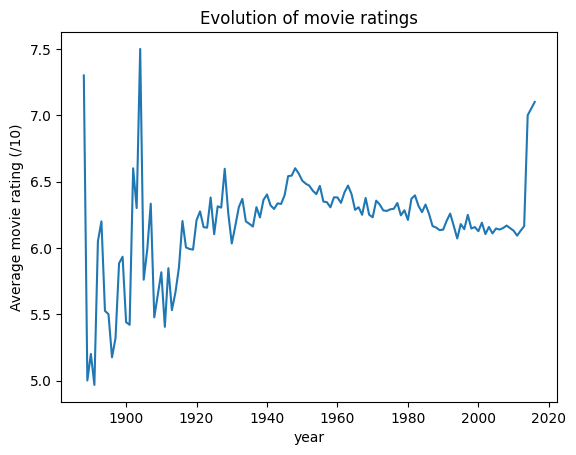

In [65]:
#Plot the distribution
imdb_rating_gp_year.plot(legend=False)
plt.ylabel('Average movie rating (/10)')
plt.xlabel('year')
plt.title('Evolution of movie ratings')

In [66]:
# Merge imdb et movie metadata
imdb.sort_values(by = 'startYear', ascending = False).head()

,Unnamed: 0,freebase_movie_ID,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
16661,17361,/m/0c03gcc,tt2267968,movie,Kung Fu Panda 3,Kung Fu Panda 3,2016,95,"Action,Adventure,Animation",7.1,159714
27214,28351,/m/0j9m0k2,tt2357291,movie,Rio 2,Rio 2,2014,101,"Adventure,Animation,Comedy",6.3,91239
28884,30082,/m/0k3lpxc,tt5308316,tvEpisode,Saving Mr. Banks,Saving Mr. Banks,2014,6,"Documentary,Short",7.4,15
30259,31517,/m/0k0tq97,tt1587310,movie,Maleficent,Maleficent,2014,97,"Adventure,Family,Fantasy",6.9,375978
39092,40653,/m/0fkf28,tt0816692,movie,Interstellar,Interstellar,2014,169,"Adventure,Drama,Sci-Fi",8.6,1803725


### 6.5 - Correlation between rating and box office revenue

- Now we have two measures of a movie's success and we wonder wether these two features are correlated. As we saw in the previous parts, there are many missing values on box office revenues. If these two features are strongly correlated, we could keep only rating as a measure of success and have a larger dataset to work on. 

In [67]:
#Merge movies with box office revenue and dataset with ratings on freebase_movie_ID
correl = movies_with_bor.merge(imdb, left_on='freebase_movie_ID', right_on='freebase_movie_ID')
correl.head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres,movie_countries_id,...,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],...,0,tt0228333,movie,Ghosts of Mars,Ghosts of Mars,2001,98,"Action,Horror,Sci-Fi",4.9,55235
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",[/m/09c7w0],...,4,tt0029852,movie,Alexander's Ragtime Band,Alexander's Ragtime Band,1938,106,"Drama,Music,Musical",6.9,2159
2,171005,/m/016ywb,Henry V,1989,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",[/m/07ssc],...,7,tt0097499,movie,Henry V,Henry V,1989,137,"Biography,Drama,History",7.5,30162
3,77856,/m/0kcn7,Mary Poppins,1964,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",[/m/09c7w0],...,8,tt0058331,movie,Mary Poppins,Mary Poppins,1964,139,"Comedy,Family,Fantasy",7.8,173169
4,156558,/m/014k4y,Baby Boy,2001,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",[/m/09c7w0],...,14,tt0255819,movie,Baby Boy,Baby Boy,2001,130,"Crime,Drama,Romance",6.4,14981


In [68]:
#Compute Pearson correlation coefficient
stats.pearsonr(correl['movie_box_off_rev'],correl['numVotes'])

PearsonRResult(statistic=0.6451295059726352, pvalue=0.0)

# P3

- The Pearson linear coefficient is low but significantly positive ($ p < 0.05$). The correlation seems too low to keep only one feature as a measure of success. 

We will take a look to the percentage of female per genre looking only to the selected genres: Drama, Comedy, Romance Film, Action and Thriller.

In [69]:
# Create a new dataset where movie genres are put into separate lines
movie_genres_female_exploded = movies_female[['movie_genres', 'female']].explode('movie_genres').dropna()
# Rename the colum 
movie_genres_female_exploded = movie_genres_female_exploded.rename(columns = {'female': 'female_ratio'})
# Compute the average of the ratio of female per genre
movie_genres_female_mean = movie_genres_female_exploded.groupby('movie_genres').mean()

# Keep only the selected genres
bool = ((movie_genres_female_mean.index == 'Drama') |
        (movie_genres_female_mean.index == 'Comedy')|
        (movie_genres_female_mean.index == 'Romance Film')|
        (movie_genres_female_mean.index == 'Action')|
        (movie_genres_female_mean.index == 'Thriller'))

movie_genres_female = movie_genres_female_mean[bool]
movie_genres_female.head(5)

,female_ratio
movie_genres,
Action,0.255917
Comedy,0.327129
Drama,0.368258
Romance Film,0.405766
Thriller,0.317919


Now that we have the average of the ratio per genre, we will test two ways to represent the results: bar plot and box plots

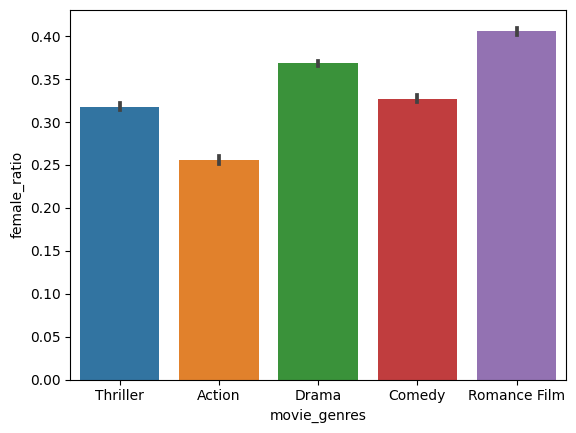

In [70]:
ax = sns.barplot(x="movie_genres", y="female_ratio", data=movie_genres_female_exploded.loc[movie_genres_female_exploded['movie_genres'].isin(['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller'])])

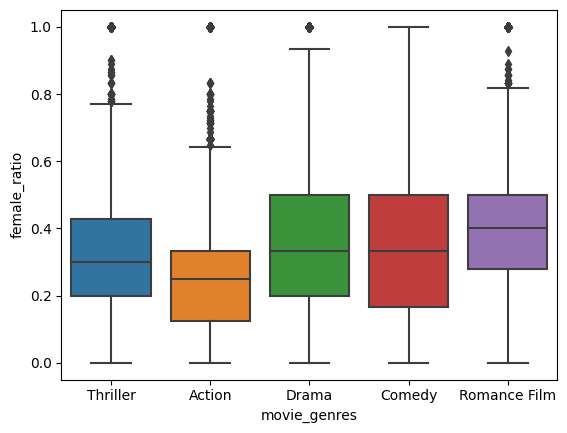

In [71]:
# Other way, maybe clearest, to represent the same thing
ax = sns.boxplot(x="movie_genres", y="female_ratio", data=movie_genres_female_exploded.loc[movie_genres_female_exploded['movie_genres'].isin(['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller'])])


### Study of apparition of actors and actress in plot summary to quantify its importance in the movie

In [72]:
# Read plot dataset
plot_df = pd.read_csv('Data/MovieSummaries/plot_summaries.txt', names = ['wiki_movie_ID', 'plot'], delimiter= '	')

In [73]:
# Sorted out the characters and plot dataframe to keep only the matching wiki_movie_ID rows
characters_filtered = characters.dropna(subset = 'character_name')
characters_filtered = characters_filtered[characters_filtered.wiki_movie_ID.isin(plot_df.wiki_movie_ID)]
plot_df_filtered = plot_df[plot_df.wiki_movie_ID.isin(characters_filtered.wiki_movie_ID)]

In [74]:
# Function to determine if a character's full name or just a part, appears in the plot
count_apparition = []
for index, row in characters_filtered.iterrows():
    names = row.character_name.split(' ')
    count = 0
    for word in names:
        if word in plot_df_filtered[plot_df_filtered.wiki_movie_ID == row.wiki_movie_ID]['plot'].item():
            count = 1
            break
    count_apparition.append(count)
characters_filtered['mentionned_in_the_plot'] = count_apparition
characters_filtered['mentionned_in_the_plot'] = pd.to_numeric(characters_filtered['mentionned_in_the_plot'])
characters_filtered.head()

,wiki_movie_ID,freebase_movie_ID,movie_release_date,character_name,actor_DOB,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie,freebase_char/actor_map_ID,freebase_char_ID,freebase_actor_ID,mentionned_in_the_plot
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,0


In [75]:
# Now we compute the mean of a mention in movie summaries per actors and per 
characters_grouped = characters_filtered[['freebase_actor_ID', 'mentionned_in_the_plot', 'actor_gender']].groupby(by = ['actor_gender', "freebase_actor_ID"]).agg('mean')
characters_grouped.reset_index(inplace = True)

In [76]:
# In average, ratio of apparition in plot summary
characters_grouped.groupby('actor_gender').mean()

/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_36593/641989738.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  characters_grouped.groupby('actor_gender').mean()


,mentionned_in_the_plot
actor_gender,
F,0.402606
M,0.376414


In [77]:
# Confidence interval to determine if the difference between the means are significative
mean_F = bootstrap((characters_grouped[characters_grouped.actor_gender == 'F'].mentionned_in_the_plot.values,), np.mean, confidence_level=0.95)
mean_M = bootstrap((characters_grouped[characters_grouped.actor_gender == 'M'].mentionned_in_the_plot.values,), np.mean, confidence_level=0.95)

print(f"95% confidence interval for actress: [{mean_F.confidence_interval.low} - {mean_F.confidence_interval.high}]")
print(f"95% confidence interval for actors: [{mean_M.confidence_interval.low} - {mean_M.confidence_interval.high}]")

95% confidence interval for actress: [0.3962249642884717 - 0.40906342976576704]
95% confidence interval for actors: [0.3715172602707687 - 0.3811876836992739]


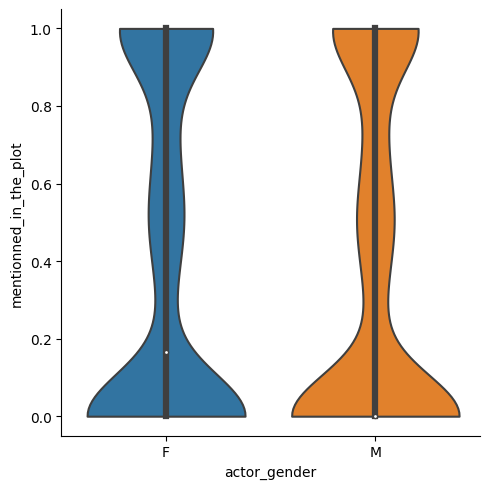

In [78]:
# Violin plot to show the distribution of the ratio of mention in plot summaries accross for both actors and actress
ax = sns.catplot(y = 'mentionned_in_the_plot', x = 'actor_gender', data = characters_grouped, kind = "violin", cut = 0, bw = .25)

# TO DO
* Checker github website
* boostrap mean 
* nature code
* score ratio + role

In [79]:
import plotly.graph_objects as go

categories = movie_genres_female.index.to_list()
female_ratio = movie_genres_female.female_ratio.to_list()
male_ratio = 1- np.array(female_ratio)

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=male_ratio,
      theta=categories + [categories[0]],
      fill='toself',
      name='Female ratio'
))

fig.add_trace(go.Scatterpolar(
      r=female_ratio,
      theta=categories,
      fill='toself',
      name='Male ratio'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.8]
    )),
  showlegend=True
)

fig.show()

In [89]:
(characters_gender.actor_gender == 'F').sum()/((characters_gender.actor_gender == 'F').sum() + (characters_gender.actor_gender == 'M').sum())

0.33279761023058313

In [96]:
((characters_gender.actor_gender == 'M').sum() ) / ((characters_gender.actor_gender == 'F').sum())

2.004829269378278

In [97]:
import chart_studio.tools as tls
tls.get_embed('https://plotly.com/~tuturta/14/')

'<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plotly.com/~tuturta/14.embed" height="525" width="100%"></iframe>'

In [104]:
import plotly.express as px
data_to_plot = characters_grouped.groupby('actor_gender').mean().reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
    name='Male',
    x=data_to_plot.actor_gender, y=data_to_plot.mentionned_in_the_plot,
    error_y=dict(type='data', array=[mean_M.confidence_interval.high - mean_M.confidence_interval.low, 
                                     mean_F.confidence_interval.high - mean_F.confidence_interval.low])
))
fig.show()



/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_36593/324034737.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [105]:
import chart_studio.plotly as py
py.plot(fig, filename = 'Apparition_in_plot_summaries', auto_open=True)

'https://plotly.com/~tuturta/28/'